# Making necessary imports

## These will be all the imports required for our project, from start to finish. This includes all the relevant data files as well.

In [3]:
## import cell

import os
import torch
import re
import random
import transformers
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer
import tqdm
from torch.utils.data import Dataset, DataLoader
import itertools
import math
import pandas as pd
import torch.nn.functional as F
import numpy as np
from torch.optim import Adam
from google.colab import drive
import matplotlib.pyplot as plt
drive.mount('/content/drive')

parquet_test = pd.read_parquet('/content/drive/MyDrive/test.parquet')
parquet_train = pd.read_parquet('/content/drive/MyDrive/train.parquet')
parquet_val = pd.read_parquet('/content/drive/MyDrive/val.parquet')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Our first goal is to get the accurate representations of the text in hand.

## Workflow

1.   Data Pre Processing
2.   Data cleaning
3.   Data Analysis  


## Data preprocessing

We are adding columns to the dataset that will make it easier for multi label classification.

In [4]:
#finding the maximum number of legal articles that could be violated. This ranges from 0 - 9.

def find_max_label(dataframe, prev_max):
  for elem in dataframe['labels']:
    for elem_2 in elem:
      prev_max = elem_2 if elem_2 > prev_max else prev_max
  return prev_max

def check_if_zero_present(dataframe):
  for elem in dataframe['labels']:
    if 0 in elem:
      print('Found zero.')
      break
  return

max_val = 0
max_val = find_max_label(parquet_test, max_val)
max_val = find_max_label(parquet_train, max_val)
max_val = find_max_label(parquet_val, max_val)

print(max_val)
check_if_zero_present(parquet_test)

9
Found zero.


In [5]:
# converting parquet dataframes into encoded values from 0 - 9 depending on which article or clause they are violating

def add_header_data_frame(dataframe, value):
  #column value = value
  append_list = []
  for elem in dataframe['labels']:
    append_list.append(1 if value in elem else 0)
  dataframe.insert(value+2, value, append_list)
  return dataframe

for i in range(0, 10):
  parquet_test = add_header_data_frame(parquet_test, i)
  parquet_train = add_header_data_frame(parquet_train, i)
  parquet_val = add_header_data_frame(parquet_val, i)


In [6]:
# This is a sample of the print we would get from the preprocessed data set.

print(parquet_test.head())

                                                text  labels  0  1  2  3  4  \
0  [5.  The applicant is a journalist for DN.no, ...     [6]  0  0  0  0  0   
1  [5.  The applicant was born in 1940 and lives ...     [4]  0  0  0  0  1   
2  [5.  The applicant was born in 1965 and lives ...     [3]  0  0  0  1  0   
3  [5.  The applicant was born in 1967 and lives ...     [3]  0  0  0  1  0   
4  [5.  The applicant was born in 1967 and lives ...  [1, 3]  0  1  0  1  0   

   5  6  7  8  9  
0  0  1  0  0  0  
1  0  0  0  0  0  
2  0  0  0  0  0  
3  0  0  0  0  0  
4  0  0  0  0  0  


## Data cleaning

This involves removing unnecessary characters and special characters from the text. So the first goal is to remove the special characters, after which we remove the numbers from the start of the paragraphs in all of the case documents. We also split the documents into sentences and give them fractional values of the labels.

In [7]:
# This is for cleaning the data given to us.

def clean_sentences(dataframe):

  count = 0
  new_list = []

  for elem in dataframe['text']:
    new_list.clear()
    for elem_2 in elem:
      value = re.sub('[^A-Za-z0-9 ]+', '', elem_2)
      value = value[3:] if value[1] == ' ' else value[4:]
      new_list.append(value)
    dataframe['text'][count] = np.array(new_list)
    count += 1

  return dataframe

parquet_test = clean_sentences(parquet_test)
parquet_train = clean_sentences(parquet_train)
parquet_val = clean_sentences(parquet_val)

<ipython-input-7-53be9b8e9648>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['text'][count] = np.array(new_list)


In [8]:
def init_new_dataframe(dataframe):
  dataframe['sentences'] = []
  for i in range(0, 10):
    dataframe[i] = []

  len(dataframe)
  return dataframe


def sentence_break_down(dataframe, new_dataframe, name):
  insert_list = []
  i = 0
  print(name)
  while i < len(dataframe):
    insert_list.clear()
    for m in range(0, len(dataframe['text'][i])):
      insert_list.clear()
      insert_list.append(dataframe['text'][i][m])
      for n in range(0, 10):
        insert_list.append(dataframe[n][i]/len(dataframe['text'][i]))
      new_dataframe.loc[len(new_dataframe)] = insert_list
    print(i)
    i += 1
  return new_dataframe

test_sentence = init_new_dataframe(pd.DataFrame())
train_sentence = init_new_dataframe(pd.DataFrame())
val_sentence = init_new_dataframe(pd.DataFrame())
test_sentence = sentence_break_down(parquet_test ,test_sentence, 'test')
train_sentence = sentence_break_down(parquet_train, train_sentence, 'train')
val_sentence = sentence_break_down(parquet_val, val_sentence, 'validation')

test
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52


KeyboardInterrupt: 

# Data Analysis

A visual plot of the article violation distribution.

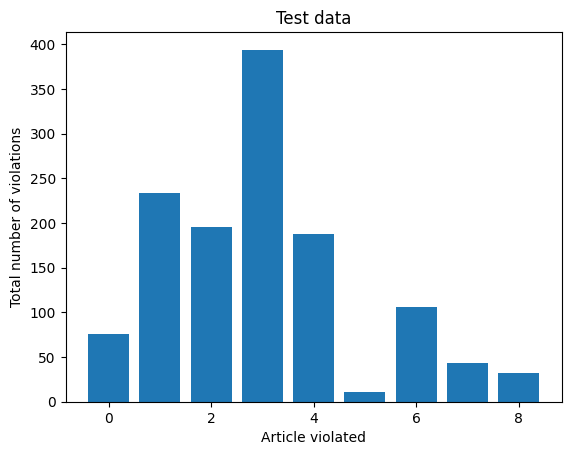

In [9]:
# This is for the test data

def find_data(dataframe, value):
  total = 0
  for elem in dataframe[value]:
    total += 1 if elem == 1 else 0
  return total

y_val = []
x_val = []

for val in range(0, 9):
  y_val.append(find_data(parquet_test, val))
  x_val.append(val)

plt.bar(x_val, y_val)
plt.xlabel('Article violated')
plt.ylabel('Total number of violations')
plt.title('Test data')
plt.show()




## Final changes

We remove the labels column after splitting all the individual documents into sentences and assigning probability values to all of the sentences, independently. We'll also normalize the values for all the bins across all the datasets.

In [61]:
# This is for removing the labels header from all of the dataframe

del parquet_test['labels']
del parquet_train['labels']
del parquet_val['labels']


In [10]:
# collapsing lines into a giant line
def sentence_group(dataframe, name):
  new_frame = init_new_dataframe(pd.DataFrame())
  i = 0
  print(name)
  append_list = []
  for elem in dataframe['text']:
    append_list.clear()
    new_string = ' '.join(elem)
    append_list.append(new_string)
    for m in range(0, 10):
      append_list.append(dataframe[m][i])
    new_frame.loc[len(new_frame)] = append_list
    i += 1
  return new_frame


test_sentence_group = sentence_group(parquet_test, 'test')
train_sentence_group = sentence_group(parquet_train, 'train')
val_sentence_group = sentence_group(parquet_val,'val')

test
train
val


In [96]:
#this is for normalizing the values in the test,train and validation sets



                                                sentences    0    1    2  \
0       At the beginning of the events relevant to the...  0.0  0.0  0.0   
1       The applicants initially cohabited from the su...  0.0  0.0  0.0   
2       K was again hospitalised from 22 April to 7 Ma...  0.0  0.0  0.0   
3       On 19 March 1993 according to the social welfa...  0.0  0.0  0.0   
4       Allegedly X did not allow K P and M to meet On...  0.0  0.0  0.0   
...                                                   ...  ...  ...  ...   
212873  As a consequence of the criminal proceedings o...  0.0  0.0  0.0   
212874  On 25 September 2008 the Pcs District Court co...  0.0  0.0  0.0   
212875  On 10 February 2010 the Baranya County Regiona...  0.0  0.0  0.0   
212876  In the ensuing proceedings on 2 July 2010 the ...  0.0  0.0  0.0   
212877  Finally in early December 2010 the applicant w...  0.0  0.0  0.0   

               3         4    5    6    7    8    9  
0       0.000000  0.012048  0.0  

# Creation of standard transformer model.

In [15]:
# Import must be pushed to the top
from transformers import AutoTokenizer, BertTokenizerFast, LongformerForSequenceClassification, LongformerTokenizer
from tqdm import tqdm

tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-base-4096")

def return_tokens(dataframe):
  append_list = []
  for i in tqdm(range(len(dataframe['sentences']))):
    tokens = tokenizer(dataframe['sentences'][i], return_tensors = "pt", truncation = True)
    append_list.append(tokens)

  return append_list

# tokens = tokenizer("hello how are you", return_tensors = "pt")

# print(len(tokens))
train_tokens = return_tokens(train_sentence_group)




100%|██████████| 9000/9000 [02:32<00:00, 58.91it/s]


In [23]:
label_vector = [i for i in range(0, 10)]
labels_batch = {k: train_sentence_group[k] for k in train_sentence_group.keys() if k in label_vector}


token_label_matrix = np.zeros((len(train_sentence_group['sentences']),len(labels_batch)))

for idx, label in enumerate(label_vector):
    token_label_matrix[:, idx] = labels_batch[label]

i = 0

while i < len(train_tokens):
  train_tokens[i]["labels"] = torch.tensor(token_label_matrix[i].tolist())
  i += 1

Streaming output truncated to the last 5000 lines.
4002
4003
4004
4005
4006
4007
4008
4009
4010
4011
4012
4013
4014
4015
4016
4017
4018
4019
4020
4021
4022
4023
4024
4025
4026
4027
4028
4029
4030
4031
4032
4033
4034
4035
4036
4037
4038
4039
4040
4041
4042
4043
4044
4045
4046
4047
4048
4049
4050
4051
4052
4053
4054
4055
4056
4057
4058
4059
4060
4061
4062
4063
4064
4065
4066
4067
4068
4069
4070
4071
4072
4073
4074
4075
4076
4077
4078
4079
4080
4081
4082
4083
4084
4085
4086
4087
4088
4089
4090
4091
4092
4093
4094
4095
4096
4097
4098
4099
4100
4101
4102
4103
4104
4105
4106
4107
4108
4109
4110
4111
4112
4113
4114
4115
4116
4117
4118
4119
4120
4121
4122
4123
4124
4125
4126
4127
4128
4129
4130
4131
4132
4133
4134
4135
4136
4137
4138
4139
4140
4141
4142
4143
4144
4145
4146
4147
4148
4149
4150
4151
4152
4153
4154
4155
4156
4157
4158
4159
4160
4161
4162
4163
4164
4165
4166
4167
4168
4169
4170
4171
4172
4173
4174
4175
4176
4177
4178
4179
4180
4181
4182
4183
4184
4185
4186
4187
4188
4189
4190
4191

In [32]:
print(type(train_tokens[0]))

format = {'type': 'torch', 'format_kwargs' :{'dtype': torch.long}}

<class 'transformers.tokenization_utils_base.BatchEncoding'>
